In [1]:
from utils import load_dataset

CST_FEATURES = "../../data/datasets/svcomp22_cst_tool.jsonl"
COUNT_FEATURES = "../../data/datasets/svcomp22_count_embedding.jsonl"
LABELS = "../../data/cpachecker_labels.jsonl"

cst_dataset = load_dataset(CST_FEATURES, LABELS, fill_unknown = True)

In [2]:
cst_dataset.embedding.shape

(6839, 128)

In [3]:
count_dataset = load_dataset(COUNT_FEATURES, LABELS, fill_unknown = True)
count_dataset.embedding.shape

(6836, 422)

In [4]:
common_instances = set.intersection(set(cst_dataset.instance_index), set(count_dataset.instance_index))

# Identify trivial instances
nontrivial = count_dataset.labels.max(axis = 1) !=  count_dataset.labels.min(axis = 1)
nontrivial = set(instance for i, instance in enumerate(count_dataset.instance_index) if nontrivial[i])
common_instances = common_instances & nontrivial
print(len(common_instances))

3932


In [5]:
common_instances = list(sorted(common_instances))

def _index_elements(obj, index):
    try:
        return obj[index]
    except Exception:
        index = set(index)
        return [o for i, o in enumerate(obj) if i in index]

from utils import Dataset

cst_index = {k: i for i, k in enumerate(cst_dataset.instance_index)}
cst_indices = [cst_index[k] for k in common_instances]
cst_dataset  = Dataset(*map(lambda x: _index_elements(x, cst_indices), cst_dataset[:-1]), cst_dataset.label_index)

count_index = {k: i for i, k in enumerate(count_dataset.instance_index)}
count_indices = [count_index[k] for k in common_instances]
count_dataset = Dataset(*map(lambda x: _index_elements(x, count_indices), count_dataset[:-1]), count_dataset.label_index)

print(cst_dataset.embedding.shape, count_dataset.embedding.shape)


(3932, 128) (3932, 422)


In [6]:
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer

prune_factor = 0.01

tfidf_embedding = TfidfTransformer().fit_transform(count_dataset.embedding).todense()
occurrence_matrix = (tfidf_embedding != 0).astype(int).mean(axis = 0)

# Stupid but works
output = []
for i, p in enumerate(occurrence_matrix.tolist()[0]):
    if p >= prune_factor:
        output.append(tfidf_embedding[:, i])

tfidf_embedding = np.hstack(output)
tfidf_embedding.shape


(3932, 271)

In [7]:
from matplotlib import pyplot as plt

def visualize(positions, colors = "black", alpha = 0.5):
    plt.figure(figsize=(16,10))
    sc = plt.scatter(positions[:, 0], positions[:,1], c = colors, alpha = alpha)

    #cbar = plt.colorbar(sc)
    #cbar.set_label('X+Y')

    plt.show()

# Problem: Abandoned instances

Algorithm selectors can only work iff the examples in the dataset are representative. In other words, if a tool
solves a task A and all similar tasks, then the tool should solve a task B that is similar to A.

There exists instances in the SVComp dataset that are impossible to solve by algorithm selection (i.e. all similar instances need another tool).

## Proof: A simple representation

In [8]:
%load_ext autoreload
%autoreload 2
from scores import wnn_ind_scores

print(count_dataset.label_index)
oracle, pred = wnn_ind_scores(tfidf_embedding, count_dataset.labels, alpha = 5)
print(oracle)

['bmc', 'ki', 'pa', 'symbolic', 'va', 'vaitp']
0.9003051881993896


In [9]:
print(pred)

[1. 1. 1. ... 1. 1. 1.]


In [10]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

n_components = 50
pca = PCA(n_components=n_components)
lsa = make_pipeline(StandardScaler(), pca)

tfidf_lsa_matrix = lsa.fit_transform(tfidf_embedding)
tfidf_lsa_matrix

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,  init='random')
tfidf_embed_matrix = tsne.fit_transform(tfidf_lsa_matrix)

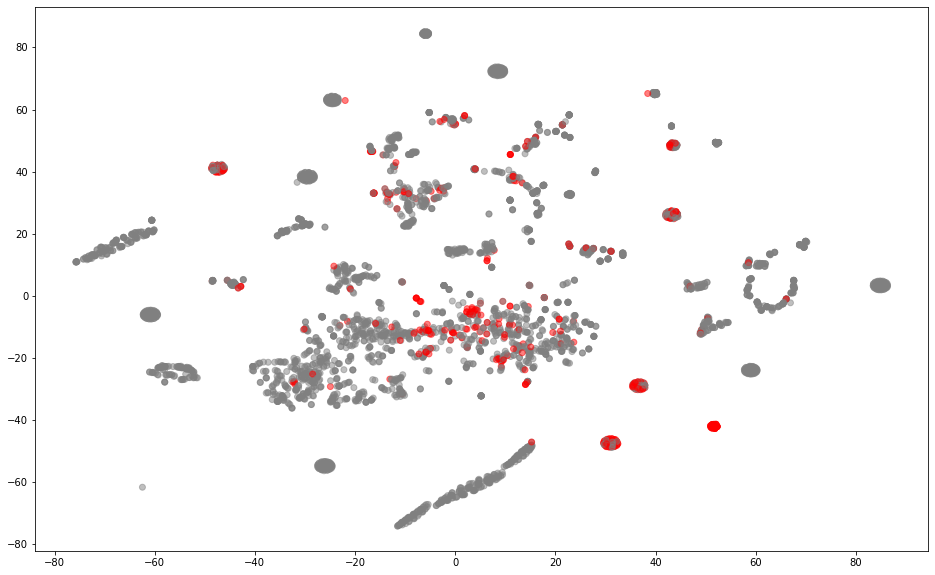

In [11]:
visualize(tfidf_embed_matrix, colors = ["red" if p == 0 else "gray" for p in pred])

# Solution 1: Better representation

In [12]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

n_components = 128
lsa = make_pipeline(StandardScaler(), PCA(n_components = n_components))


tfidf_matrix = TfidfTransformer().fit_transform(count_dataset.embedding).todense()
tfidf_lsa_embedding = lsa.fit_transform(tfidf_matrix)

print(tfidf_lsa_embedding.shape)

score, pred = wnn_ind_scores(tfidf_lsa_embedding, count_dataset.labels, alpha = 5)
print(score)


(3932, 128)
0.9270091556459817


In [13]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

n_components = 50
pca = PCA(n_components=n_components)
lsa = make_pipeline(StandardScaler(), pca)

tfidf_lsa_matrix = lsa.fit_transform(tfidf_lsa_embedding)
tfidf_lsa_matrix

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,  init='random')
tfidf_embed_matrix = tsne.fit_transform(tfidf_lsa_matrix)

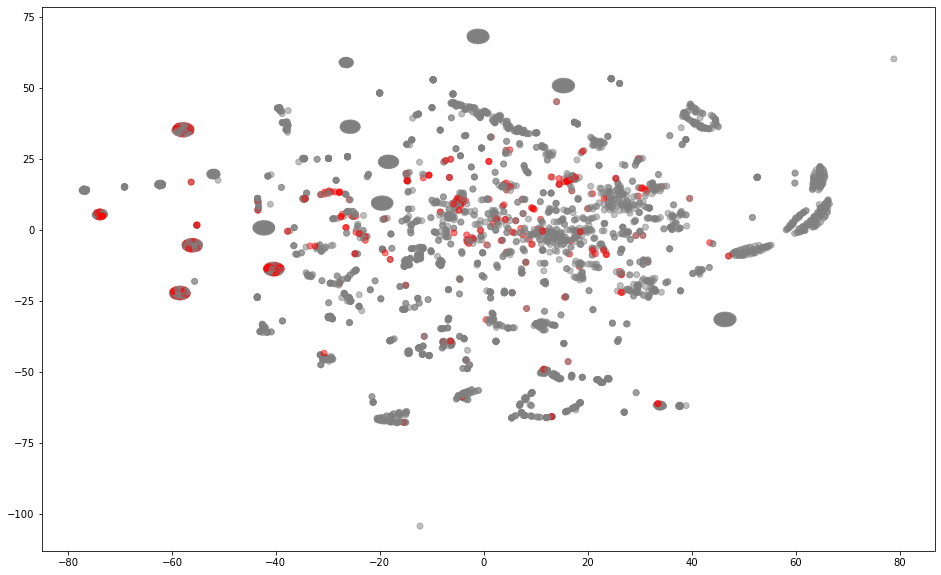

In [14]:
visualize(tfidf_embed_matrix, colors = ["red" if p == 0 else "gray" for p in pred])

# Solution 1.2 CST

In [15]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

n_components = 128
lsa = make_pipeline(StandardScaler(), PCA(n_components = n_components, whiten = True))
tfidf_lsa_embedding = lsa.fit_transform(cst_dataset.embedding)

print(tfidf_lsa_embedding.shape)

score, pred = wnn_ind_scores(tfidf_lsa_embedding, count_dataset.labels, alpha = 5)
print(score)

(3932, 128)
0.9465920651068158


In [16]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

n_components = 50
pca = PCA(n_components=n_components)
lsa = make_pipeline(StandardScaler(), pca)

tfidf_lsa_matrix = lsa.fit_transform(tfidf_lsa_embedding)
tfidf_lsa_matrix

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,  init='random')
tfidf_embed_matrix = tsne.fit_transform(tfidf_lsa_matrix)

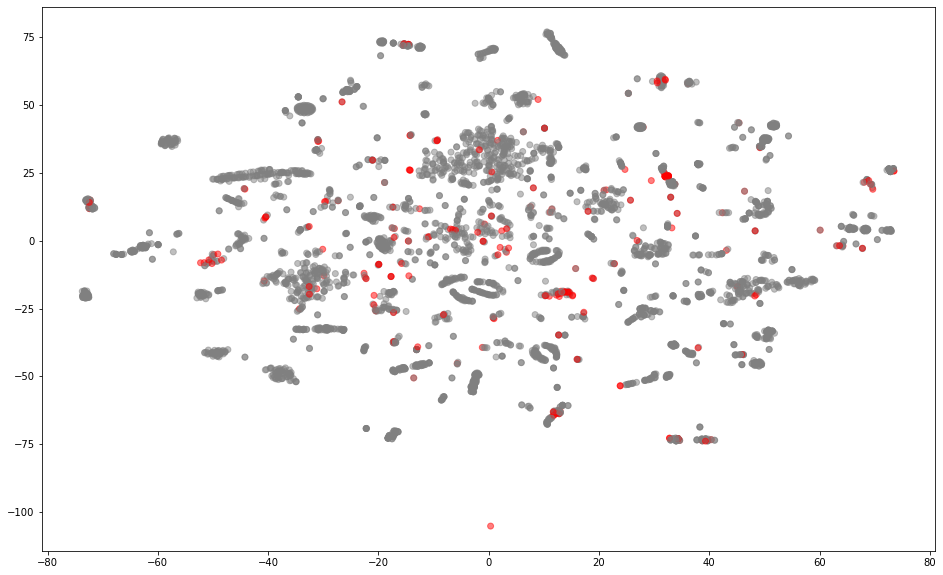

In [17]:
visualize(tfidf_embed_matrix, colors = ["red" if p == 0 else "gray" for p in pred])

# Solution 2: Klee

In [18]:
import json

with open("../../data/klee_labels.jsonl", "r") as inp:
    klee = [json.loads(i) for i in inp]

In [19]:
from utils import _path_to_task_id
klee_solved = [_path_to_task_id(e[0]["task_file"]) for e in klee if "false" in e[0]["status"]]

In [20]:
instance_index = set(cst_dataset.instance_index)
extra_solved = set(klee_solved) - instance_index
print("Klee solves %d instances which could not be solved or were trivial" % len(extra_solved))

Klee solves 721 instances which could not be solved or were trivial


In [21]:
common_solved = set(klee_solved) & instance_index
print("Klee solves %d instances that were open for prediction" % len(common_solved))

Klee solves 809 instances that were open for prediction


In [22]:
cst_index = {k: i for i, k in enumerate(cst_dataset.instance_index)}
cst_indices = [cst_index[k] for k in cst_dataset.instance_index if k not in klee_solved] 
cst_klee_dataset  = Dataset(*map(lambda x: _index_elements(x, cst_indices), cst_dataset[:-1]), cst_dataset.label_index)
cst_klee_dataset.embedding.shape

(3123, 128)

In [33]:
n_components = 128
lsa = make_pipeline(StandardScaler(), PCA(n_components = n_components, whiten = True))
tfidf_lsa_embedding = lsa.fit_transform(cst_klee_dataset.embedding)

print(tfidf_lsa_embedding.shape)

score, pred = wnn_ind_scores(tfidf_lsa_embedding, cst_klee_dataset.labels, alpha = 5, k = 1)

K = tfidf_lsa_embedding.shape[0]
N = cst_dataset.embedding.shape[0]
score = (K / N * score + (1 - K / N))

print(score)

(3123, 128)
0.9560020345879959


In [24]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

n_components = 50
pca = PCA(n_components=n_components)
lsa = make_pipeline(StandardScaler(), pca)

tfidf_lsa_matrix = lsa.fit_transform(tfidf_lsa_embedding)
tfidf_lsa_matrix

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,  init='random')
tfidf_embed_matrix = tsne.fit_transform(tfidf_lsa_matrix)

# Solution 3: Portfolio

In [44]:
n_components = 128
lsa = make_pipeline(StandardScaler(), PCA(n_components = n_components, whiten = True))
tfidf_lsa_embedding = lsa.fit_transform(cst_dataset.embedding)

print(tfidf_lsa_embedding.shape)

labels = count_dataset.labels
runtimes = (count_dataset.runtimes <= 450).astype(int)
labels = labels * runtimes

score, pred = wnn_ind_scores(tfidf_lsa_embedding, labels, alpha = 5, k = 2)
print(score)

(3932, 128)
0.9425228891149542


In [49]:
labels = cst_klee_dataset.labels
runtimes = (cst_klee_dataset.runtimes <= 450).astype(int)
labels = labels * runtimes

n_components = 128
lsa = make_pipeline(StandardScaler(), PCA(n_components = n_components, whiten = True))
tfidf_lsa_embedding = lsa.fit_transform(cst_klee_dataset.embedding)

print(tfidf_lsa_embedding.shape)

score, pred = wnn_ind_scores(tfidf_lsa_embedding, cst_klee_dataset.labels, alpha = 5, k = 3, score_labels = labels)

K = tfidf_lsa_embedding.shape[0]
N = cst_dataset.embedding.shape[0]
score = (K / N * score + (1 - K / N))

print(score)

(3123, 128)
0.9621057985757884
